# Assignment 1. Traditional Animation

This is the start code for miniproject 1. Please refer to the [course website](http://graphics.cs.cmu.edu/nsp/course/15464-s19/www/assignments/miniProject1.htm) for instructions.

## Part I. Set up environment
- Python3.7: [https://www.anaconda.com/distribution/](https://www.anaconda.com/distribution/)
- ffmpeg: [https://www.ffmpeg.org/download.html](https://www.ffmpeg.org/download.html)

## Part II. Understand data
Sample motions are given under data folder in BVH format. BVH format has two parts, i.e. skeleton hierarchy and motion. $\bf{HIERARCHY}$ section defines joint names, joint relationship, degree of freedoms, and the order of euler angles. $\bf{MOTION}$ section defines number of frames, frame time interval, and the value for each degree of freedoms per joint per frame. Here is one simplified example of bvh file:
```
HIERARCHY
ROOT Hips
{
	OFFSET 0.000000 0.000000 0.000000
	CHANNELS 6 Xposition Yposition Zposition Zrotation Yrotation Xrotation 
	JOINT Spine
	{
		OFFSET 0.000000 10.000000 0.000000
		CHANNELS 3 Zrotation Yrotation Xrotation
		End Site
		{
			OFFSET 0.000000 10.000000 0.000000
		} 
	}
}
MOTION
Frames: 2
Frame Time: 0.033333
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 90
```

In $\bf{HIERARCHY}$ section, we could read
- Joint names: There are three joints, "Hips", "Spine", and an end site. 
- Joint relationship (tree structure): "Hips" is the parent joint of "Spine", and "Spine" is the parent joint of the end site. 
- Degree of freedoms: "Hips" has 6 degree of freedom (i.e. 6 channels).
- Order of Euler angle: The order of rotations channels is the order or euler angle. Here, the euler angle order is ZYX, i.e. $v'=R_ZR_YR_Xv$

In $\bf{MOTION}$ section, we could read
- Number of frames: 2
- Frame time interval: 0.033333, i.e. 30 fps
- Motion data for each degree of frame per frame: There are 2 lines and each line represent one time frame. The visualization of these two frames look like

![alt text](data/Simple.jpg)

## Part III. Load and save BVH files
We have already provided start code to load and save bvh files

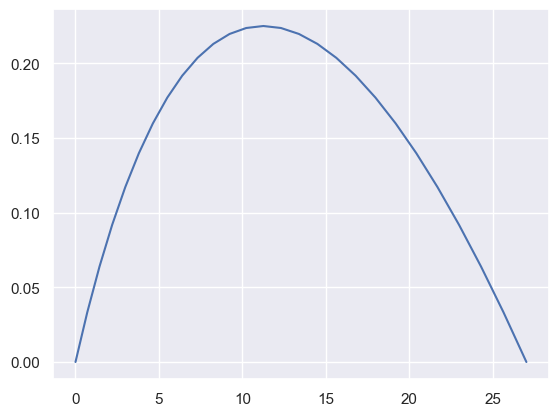

In [2]:
import os
import argparse
import numpy as np
import bezier
import matplotlib.pyplot as plt

import sys
sys.path.append('common')
from BVH import load, save
from Quaternions import Quaternions

src_path = 'data/Walking_01.bvh'
dst_path = 'output/'
os.makedirs(dst_path, exist_ok=True)

anim, joint_names, frame_time, order = load(src_path)                             # Load data from bvh file

def joint_index(joint_name):
    return joint_names.index(joint_name)
# thoughts: take a walk cycle, rotate the root by a few degrees on the downs of the walk cycle?
# Make walk cycle a swim
# Posture correction?
# Exploring preserving the loop!!! This should be the focus
# Smooth (delete half then linear interpolate between the two)
# Maybe find the lowest point of the root and use that to get the downs
# Same for the ups
anim.positions[:,0,2] = 0 # freeze the root in place for looping
frame_length = anim.positions.shape[0]
# third value in rotations is a quaternion of x,y,z,w
lowest_point = 0
lowest_point_frame = -1
for i in range(frame_length):
    # Todo: This needs to be in world space ahhh
    root_y_pos = anim.positions[i,0,1]
    # I would assume I would be checking this backwards but it seems to work correctly
    if(root_y_pos > lowest_point):
        # print("New lowest point " + str(root_y_pos) + " at frame " + str(i))
        lowest_point = root_y_pos
        lowest_point_frame = i
rotate_peak_strength = 0.45
# Bezier curve with a fraction of rotation applied each frame. For frame = 0 or frame = frame_length, rotation is 0. For frame = lowest_point, rotation is 1
nodes = np.asfortranarray([[0, lowest_point_frame, frame_length], [0, rotate_peak_strength,0]])
#todo: graph X Y and Z as a function of frame
# nodes = np.asfortranarray([[0, lowest_point_frame, frame_length], [1,lowest_point, 1]])
curve = bezier.Curve.from_nodes(nodes)
ax = curve.plot(num_pts=frame_length)
# Print the lowest point root rotate amount from matplotlib ax
curve_yvals = ax.lines[0].get_ydata()
#Evaluate the curve for the frame length to determine the Z component of the quaternion in anim.rotations
curve_values = curve.evaluate_multi(np.linspace(0,frame_length, frame_length))
# Array containing the evaluated curve values for each frame, with the first row as all all values and the second row as all 0s and the third row the new value
# Spine 1, spine 2, spine 3
joints_to_rotate = ["Spine","Spine2","Spine1","Head"]
apply_strength = [0.35,0.5,0.75,1]
joints_info = np.array([[joint_index(j) for j in joints_to_rotate],apply_strength])
for i in range(frame_length):
    # print(curve_values[0,i])
    # quat_array = np.array([0,0,anim.rotations[i,0].euler()[0,2] + np.clip(curve_yvals[i],0,1)])
    for j in joints_info:
        # print("Joint " + str(j[0]) + " apply strength " + str(j[1]))
        # Multiply by strength and clip to 1 (rot can't be above 1)
        quat_array = np.array([anim.rotations[i,int(j[0])].euler()[0,2] + np.clip(curve_yvals[i] * j[1],0,1),0,0])
        anim.rotations[i,int(j[0])] = Quaternions.from_euler(quat_array)


# for i in range(frame_length):
#     if i % 16 != 0:
#         lerp_amount = i % 16 / 16
#         current_z_rotation = anim.rotations[i,0].euler()[0,2]
#         print("Current z rot " + str(current_z_rotation))
#         # Clip to limit of 1
#         quat_array = np.array([0,0,current_z_rotation + np.clip((root_rotate_amount * lerp_amount),0,1)])
#         print("New Z quaternion" + str(quat_array))
#         anim.rotations[i,0] = Quaternions.from_euler(quat_array)
#         # print(anim.rotations[i,0])
#         #np.quaternion.from_euler_angles(0, 0, np.deg2rad(root_rotate_amount * lerp_amount))


# for i in range(frame_length):
#     anim.positions[i,0,2] = 0
save(os.path.join('output', 'output.bvh'), anim, joint_names, frame_time, order)   # Save data to bvh file

anim is an instance of Animation class, which defines orients, offsets, translations, and rotations. Denote the number of frames as $F$, number of joint as $J$, then the dimension for each variables are:
- orients: (J, Quaternion). Quaternion is class defined under common/Quaternions.py.
- offsets: (J, 3)
- positions: (F, J, 3)
- rotations: (F, J, Quaternion)

We can check the shape of each variable as follows:

In [2]:
anim.orients.qs.shape

(67, 4)

In [3]:
anim.offsets.shape

(67, 3)

In [4]:
anim.positions.shape

(324, 67, 3)

In [5]:
anim.rotations.qs.shape

(324, 67, 4)

In [63]:
joint_names[:]

['Hips',
 'Spine',
 'Spine1',
 'Spine2',
 'Neck',
 'Head',
 'HeadTop_End',
 'LeftEye',
 'RightEye',
 'LeftShoulder',
 'LeftArm',
 'LeftForeArm',
 'LeftHand',
 'LeftHandThumb1',
 'LeftHandThumb2',
 'LeftHandThumb3',
 'LeftHandThumb4',
 'LeftHandIndex1',
 'LeftHandIndex2',
 'LeftHandIndex3',
 'LeftHandIndex4',
 'LeftHandMiddle1',
 'LeftHandMiddle2',
 'LeftHandMiddle3',
 'LeftHandMiddle4',
 'LeftHandRing1',
 'LeftHandRing2',
 'LeftHandRing3',
 'LeftHandRing4',
 'LeftHandPinky1',
 'LeftHandPinky2',
 'LeftHandPinky3',
 'LeftHandPinky4',
 'RightShoulder',
 'RightArm',
 'RightForeArm',
 'RightHand',
 'RightHandPinky1',
 'RightHandPinky2',
 'RightHandPinky3',
 'RightHandPinky4',
 'RightHandRing1',
 'RightHandRing2',
 'RightHandRing3',
 'RightHandRing4',
 'RightHandMiddle1',
 'RightHandMiddle2',
 'RightHandMiddle3',
 'RightHandMiddle4',
 'RightHandIndex1',
 'RightHandIndex2',
 'RightHandIndex3',
 'RightHandIndex4',
 'RightHandThumb1',
 'RightHandThumb2',
 'RightHandThumb3',
 'RightHandThumb4',


### Practice: What shall we do to read the data for "LeftShoulder"?
### Solution:

In [7]:
left_shoulder_id = joint_names.index("LeftShoulder")
print('LeftShoulder id', left_shoulder_id)
lshoulder_rotations = anim.rotations[:, left_shoulder_id]
print('Frame 0', lshoulder_rotations.qs[0])    # (w, x, y, z)
print('Frame 1', lshoulder_rotations.qs[1])

LeftShoulder id 9
Frame 0 [ 0.99726561  0.00877797 -0.05641605 -0.04691997]
Frame 1 [ 0.99738512  0.00882779 -0.06070663 -0.03820599]


## Part IV. Visualize data

You could always import BVH files in softwares such as Maya, Unity, Motion Builder. We also provided code to visualize motion data to mp4 files for an easy checkup. Make sure you have installed ffmpeg before running visualization.

In [3]:
import os
import argparse
import numpy as np
import glob

import sys
sys.path.append('common')

dst_path = 'output/'

from Visualize import visualize_anim

name = os.path.basename(src_path).split('.')[0]
existing_videos = glob.glob(os.path.join(dst_path, name + '*.mp4'))
# If video already exists, delete it
if len(existing_videos) > 0:
    for video in existing_videos:
        os.remove(video)
visualize_anim(anim, title=None, img_dir=os.path.join(dst_path, name), multi_view=False,
               video_path=os.path.join(dst_path, name + ".mp4"))


In [4]:
from IPython.display import Video
Video(os.path.join(dst_path, name + "_3d" + ".mp4"), embed=True, html_attributes="loop autoplay muted")


### Reference:
- Holden, D., Komura, T., & Saito, J. (2017). Phase-functioned neural networks for character control. ACM Transactions on Graphics (TOG), 36(4), 42.
- https://research.cs.wisc.edu/graphics/Courses/cs-838-1999/Jeff/BVH.html